# TP de Lógica Difusa

## Control de temperatura de una habitación mediante un controlador difuso

**Descripción del problema**

En un laboratorio industrial se requiere mantener la temperatura ambiente ($T_{i}$) en valores constantes ($R$) de forma de poder asegurar la calidad en una
etapa crı́tica en la producción. La habitación es de 3 × 2 × 2 m, con paredes de ladrillo de 15 cm y una única entrada con un sistema de cierre automático
que asegura un tiempo máximo de apertura de 10 s. Dicha puerta se abre una vez por hora, cuando el personal debe ingresar para realizar tareas de manteniemiento.

Para lograr controlar la temperatura en la habitación se dispone de un sistema de convección con una resistencia calefactora (no incandescente) y un aire acondicionado. Ambos dispositivos poseen interruptores que permiten regular el trabajo que realizan (rango 0-100%, siendo 100% el funcionamiento máximo del equipo).

La habitación puede experimentar cambios en la $T_{i}$ debido principalmente a 4 factores:

1. Calor aportado desde el exterior a través de las paredes,
2. Corriente que circula por la resistencia calefactora,
3. Tensión aplicada al sistema de refrigeración,
4. Calor que ingresa al abrir la puerta.

Se desea diseñar 2 sistemas difusos para controlar los sistemas de regulación de temperatura, de manera de preservar la temperatura interna de acuerdo a los valores de referencia preestablecidos.

Para probar los controladores se provee un modelo digital de la habitación, y un conjunto de condiciones para la simulación que reflejan el típico comportamiento de la habitación.

Se solicita que:

- El sistema diseñado provea un error de control acumulado inferior a 1300 $°C/h$ (este valor se provee automáticamente al finalizar la simulación).

- Analice las características del sistema diseñado y discuta las limitaciones que identifique.

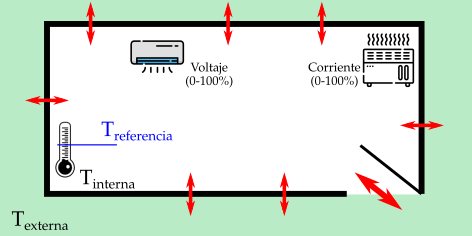

### Instalación y carga de librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import skfuzzy as fuzz
from skfuzzy import control as ctrl

## Construcción del controlador difuso

En esta Sección se debe diseñar el controlador difuso que manejará el sistema de temperaturas.

**CALEFACTOR**

In [2]:
# ANTECEDENTES
dT = ctrl.Antecedent(np.arange(0,26,1), 'error')

# CONSECUENTES
calefactor = ctrl.Consequent(np.arange(0,101,1), 'salida')

# ERROR - CONJUNTOS DIFUSOS
dT['bajo'] = fuzz.trimf(dT.universe, [0, 5, 10])
dT['medio'] = fuzz.trimf(dT.universe, [5, 10, 20])
dT['alto'] = fuzz.trimf(dT.universe, [10, 25, 25])

# SALIDA - CONJUNTOS DIFUSOS
calefactor['min'] = fuzz.trapmf(calefactor.universe, [5, 5, 15, 25])
calefactor['med'] = fuzz.trapmf(calefactor.universe, [15, 25, 75, 85])
calefactor['max'] = fuzz.trapmf(calefactor.universe, [75, 85, 100, 100])

# REGLAS BORROSAS
cal_min = ctrl.Rule(dT['bajo'], calefactor['min'])
cal_med = ctrl.Rule(dT['medio'], calefactor['med'])
cal_max = ctrl.Rule(dT['alto'], calefactor['max'])

#----------

# CONSTRUYO LA MAQUINA DE INFERENCIA
controlador_calefaccion = ctrl.ControlSystemSimulation(ctrl.ControlSystem([cal_min, cal_med, cal_max]))

**AIRE ACONDICIONADO**

In [3]:
# CONSECUENTES
refrigeracion = ctrl.Consequent(np.arange(0,101,1), 'salida')

# SALIDA - CONJUNTOS DIFUSOS
refrigeracion['min'] = fuzz.trapmf(refrigeracion.universe, [5, 5, 15, 25])
refrigeracion['med'] = fuzz.trapmf(refrigeracion.universe, [15, 25, 75, 85])
refrigeracion['max'] = fuzz.trapmf(refrigeracion.universe, [75, 85, 100, 100])

# REGLAS BORROSAS
ref_min = ctrl.Rule(dT['bajo'], refrigeracion['min'])
ref_med = ctrl.Rule(dT['medio'], refrigeracion['med'])
ref_max = ctrl.Rule(dT['alto'], refrigeracion['max'])

#----------

# CONSTRUYO LA MAQUINA DE INFERENCIA
controlador_refrigeracion = ctrl.ControlSystemSimulation(ctrl.ControlSystem([ref_min, ref_med, ref_max]))

### CONTROL DE TEMPERATURA

In [4]:
def controlador_difuso(dT):
    '''
    Esta función implementa el controlador difuso.
    Toma como argumento la diferencia de temperatura respecto de la referencia (dT = Tr - Ti) y define
    las acciones a tomar. Para eso, determina los valores de "voltaje" que debe aplicar al aire
    acondicionado y la "corriente" que debe aplcar al sistema calefactor para reducir el error.
    '''
    
    #-------------------------------
    # Tr == Ti: TEMPERATURA DESEADA
    #-------------------------------
    if (dT == 0):
        corriente = 0
        voltaje = 0
    
    #-------------------------------
    # Tr > Ti: HABITACION FRIA
    #-------------------------------
    if (dT > 0):
        controlador_calefaccion.input['error'] = np.abs(dT)
        controlador_calefaccion.compute()        
        corriente = controlador_calefaccion.output['salida']
        
        voltaje = 0
    
    #-------------------------------
    # Tr < Ti: HABITACION CALIENTE
    #-------------------------------
    else:
        corriente = 0
        
        controlador_refrigeracion.input['error'] = np.abs(dT)
        controlador_refrigeracion.compute()        
        voltaje = controlador_refrigeracion.output['salida']
            
    return corriente, voltaje

## Simulación

In [5]:
def habitacion(Ti, Te, a, corriente, voltaje):
    '''
    Esta función simula como cambia la temperatura dentro de la habitación en base a los argumentos recibidos.

    Ti: Temperatura interna de la habitación en el instante n-1 [°C]
    Te: Temperatura externa de la habitación en el instante n [°C]
    p: Probabilidad de que se habra la puerta una vez por hora.
    '''

    if a == 1:
        Ti = 0.169 * Ti + 0.831 * Te + 11.2 * ((corriente/100)**2) - 0.2 * voltaje/100  # PUERTA ABIERTA
    else:
        Ti = 0.912 * Ti + 0.088 * Te + 60.4 * ((corriente/100)**2) - 1.21 * voltaje/100  # PUERTA CERRADA

    return Ti

## INICIALIZACION DE PARAMETROS DE LA SIMULACION

In [6]:
Tinicial = 25  # [°C]

t_simulacion = 3600  # [s]
tm = 10  # Período de muestreo [s]


#================================================================
# Error entre la temperatura de la habitación y la de referencia
#================================================================
dT = np.zeros( t_simulacion//tm + 1)


#======================================
# Temperatura dentro de la habitación
#======================================
Ti = np.zeros( t_simulacion//tm )
Ti[0] = Tinicial
Ti[1] = Tinicial


#======================================
# Temperatura externa a la habitación
#====================================== 
Te = np.concatenate((20 * np.ones(600), # 
                     15 * np.ones(600), #
                     20 * np.ones(600), #
                     10 * np.ones(600), #
                     20 * np.ones(600), #
                     25 * np.ones(600))) #

Te = Te[0::tm]  # Muestreo de la señal


#==============================
# Temperatura de referencia
#==============================
Tr = np.concatenate((18 * np.ones(600), # 
                     22 * np.ones(600), #
                     18 * np.ones(600), #
                     22 * np.ones(600), #
                     18 * np.ones(600), #
                     22 * np.ones(600))) #

Tr = Tr[0::tm]  # Muestreo de la señal


#=================================================================================
# Apertura de la puerta (vector binario indicando con "1" si se abrió la puerta)
#=================================================================================
n = 1  # Cantidad de veces que se abre la puerta por hora
a = np.zeros(t_simulacion//tm)
a[:n] = 1
a = np.random.permutation(a)


#======================================
# Corriente alimentada al calefactor
#======================================
corriente = np.zeros( t_simulacion//tm )


#================================================
# Voltaje aplicado al sistema de refrigeración
#================================================
voltaje = np.zeros( t_simulacion//tm )

In [7]:
muestras = range(1, t_simulacion//tm)

for n in muestras:
    
    # CALCULO EL ERROR DE TEMPERATURA
    dT[n] = Tr[n-1] - Ti[n-1]
    
    
    ##########################################################################
    # APLICO EL CONTROLADOR DIFUSO
    #################################
    
    corriente[n], voltaje[n] = controlador_difuso(dT[n])
    
    ##########################################################################
    
    # CALCULO EL VALOR DE LA TEMPERATURA INTERNA DE LA HABITACION
    Ti[n] = habitacion( Ti[n-1], Te[n], a[n], corriente[n], voltaje[n] )

SSE = (dT**2).sum()

## SIMULACION

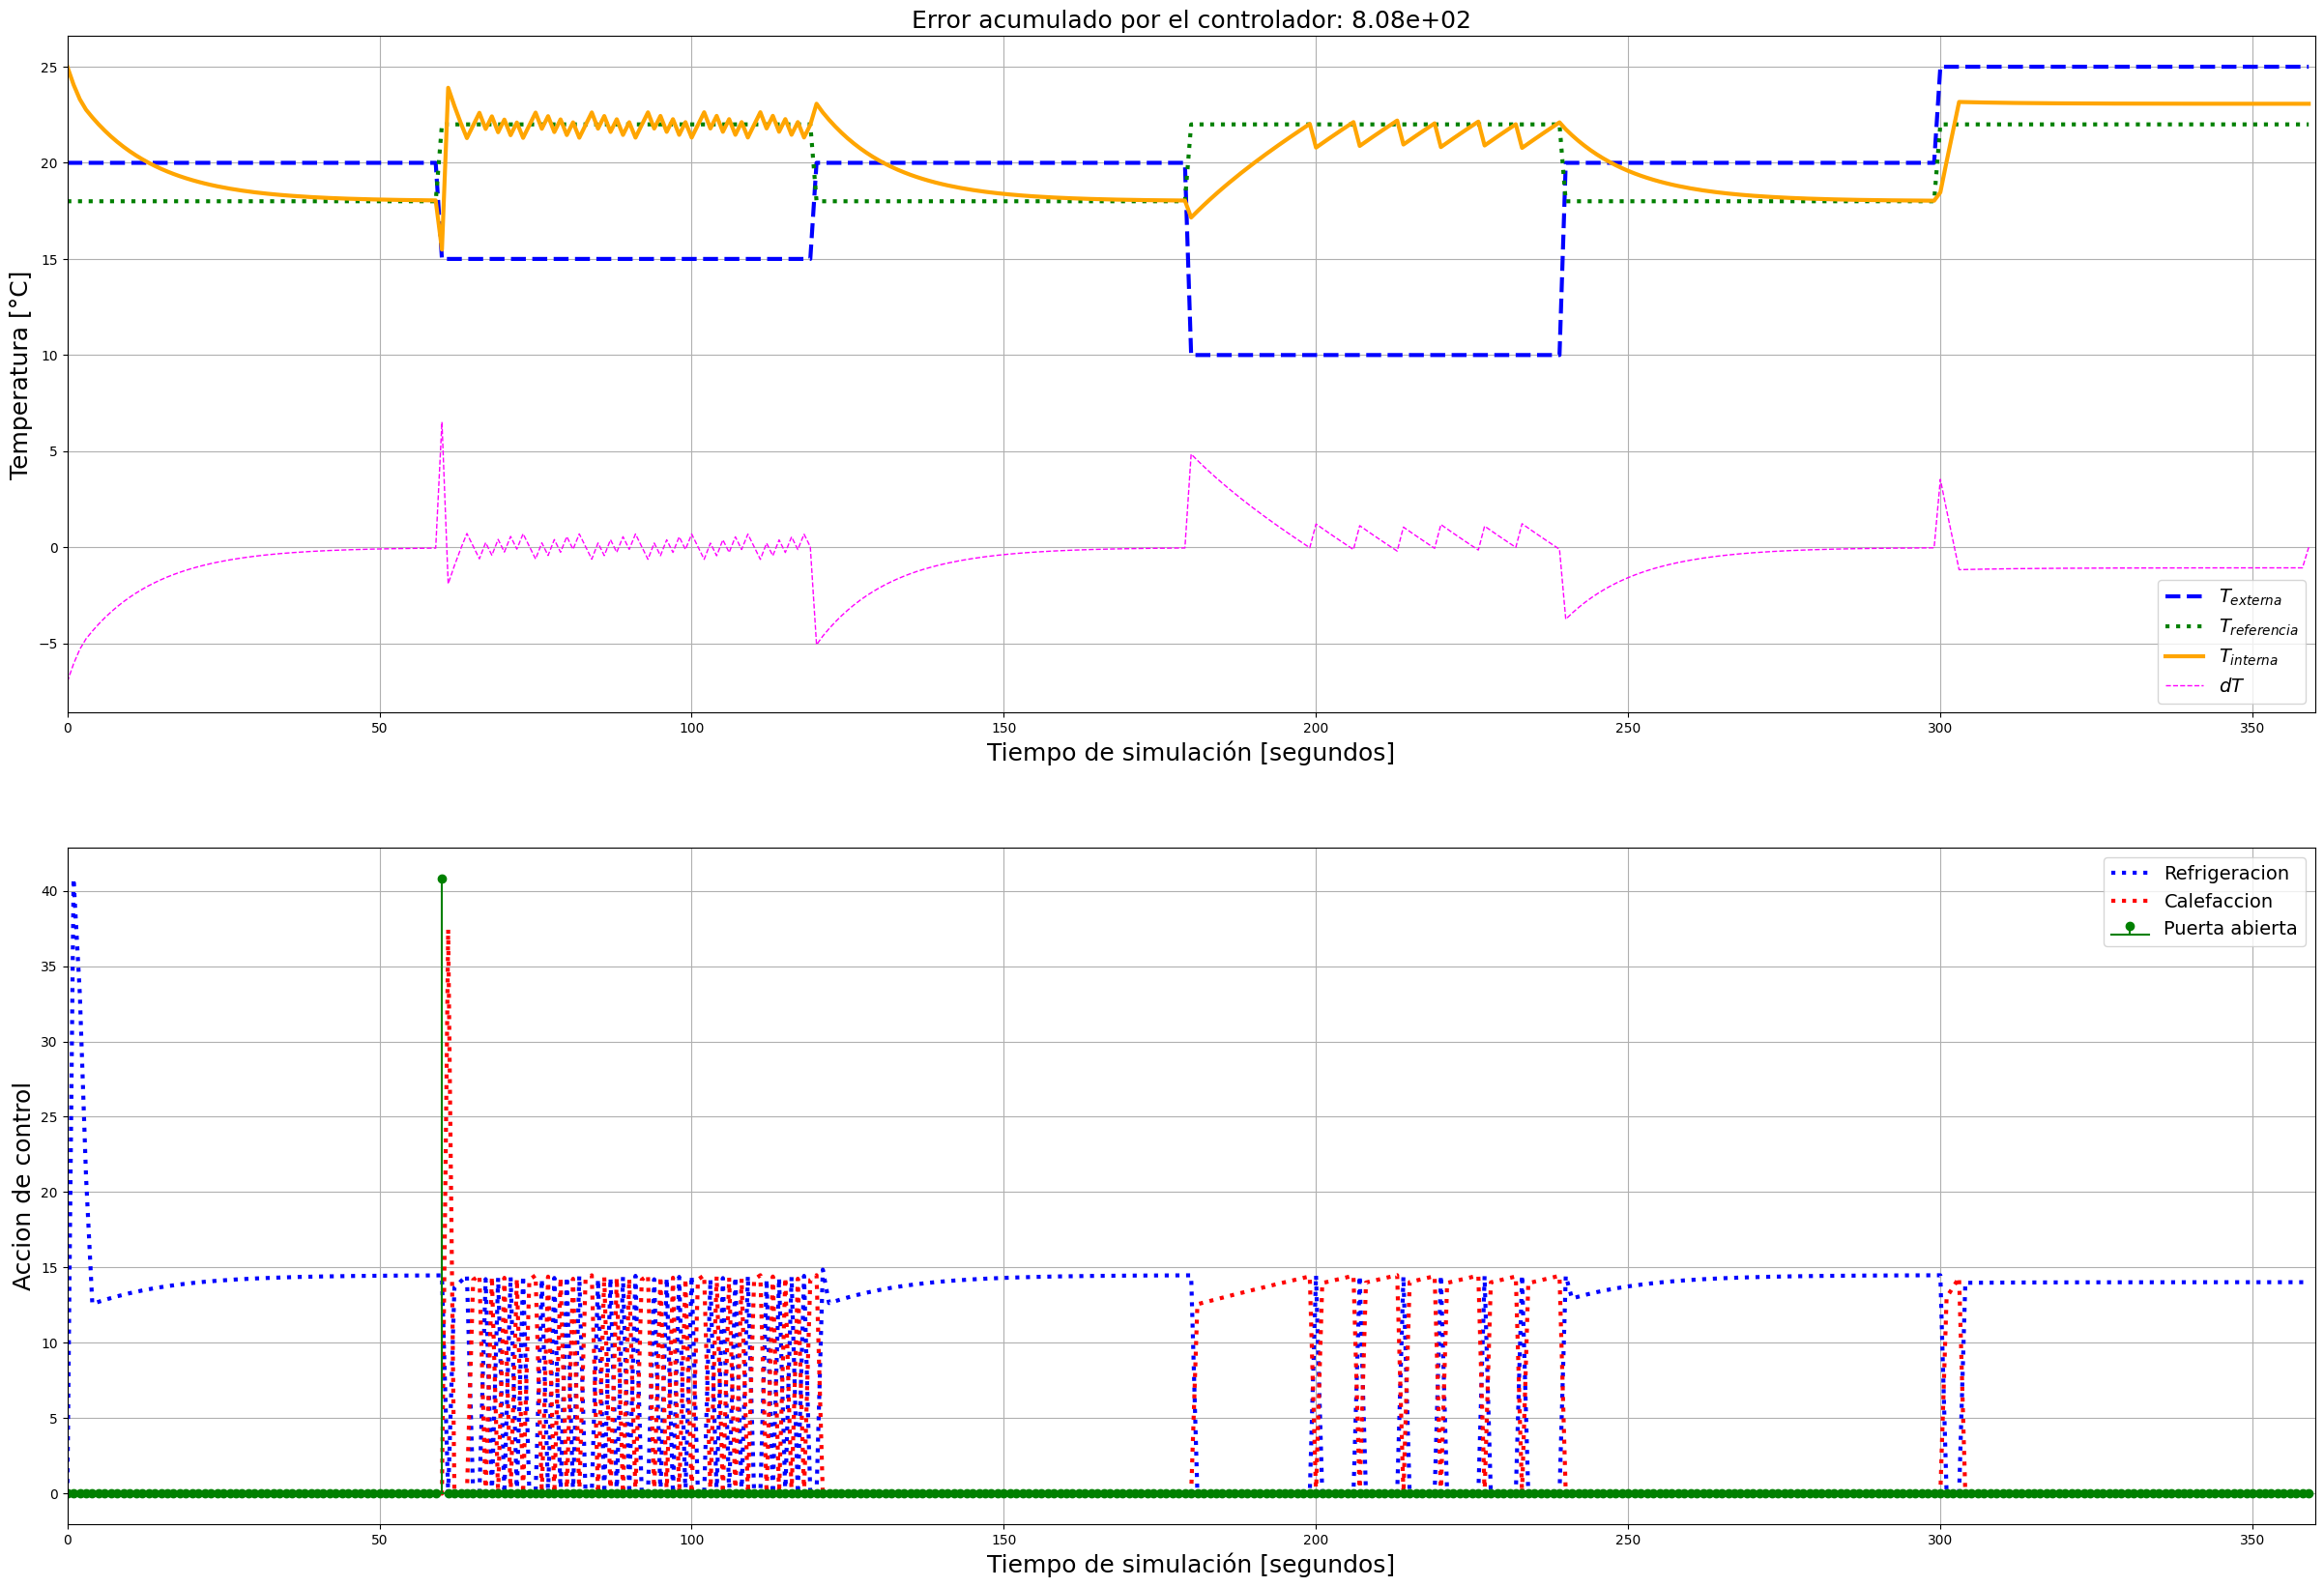

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(30,20))

tiempo = range(t_simulacion//tm)

ax[0].plot(tiempo, Te, color='blue', linestyle='--', lw=3, label=u'$T_{externa}$')
ax[0].plot(tiempo, Tr, color='green', linestyle=':', lw=3, label=u'$T_{referencia}$')
ax[0].plot(tiempo, Ti, color='orange', linestyle='-', lw=3, label=u'$T_{interna}$')
ax[0].plot(tiempo, dT[1:], color='magenta', linestyle='--', lw=1, label=u'$dT$')
ax[0].set_title(f'Error acumulado por el controlador: {SSE:0.3}', fontsize=18)
ax[0].set_xlabel('Tiempo de simulación [segundos]', fontsize=18)
ax[0].set_ylabel('Temperatura [°C]', fontsize=18)
ax[0].set_xlim([0, t_simulacion//tm])
ax[0].grid(True)
ax[0].legend(fontsize=14)


ax[1].plot(tiempo, voltaje, color='blue', linestyle=':', lw=3, label=u'Refrigeracion')
ax[1].plot(tiempo, corriente, color='red', linestyle=':', lw=3, label=u'Calefaccion')
ax[1].stem(tiempo, a * np.maximum(1, np.maximum(corriente.max(), voltaje.max())), markerfmt='go', linefmt='g-', basefmt='g-', label=u'Puerta abierta')
ax[1].set_xlabel('Tiempo de simulación [segundos]', fontsize=18)
ax[1].set_ylabel('Accion de control', fontsize=18)
ax[1].set_xlim([0, t_simulacion//tm])
ax[1].grid(True)
ax[1].legend(fontsize=14);